In [2]:
from data_fns import load_omniglot
from estimator import RFClassifier, classical_weights, V1_inspired_weights, relu, parallelized_clf
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import pickle

In [3]:
import dask
from dask.distributed import Client
client = Client(threads_per_worker=5, n_workers=5)
client

/home/bpandey/anaconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:39283 Dashboard: http://127.0.0.1:43651/status,Cluster Workers: 5 Cores: 25 Memory: 135.06 GB


In [53]:
from skimage.measure import block_reduce
original_data, labels = load_omniglot('data/omniglot-py/')
data = block_reduce(original_data,  block_size=(1, 3, 3), func=np.mean)

# load 20 characters out of the datasets
i = np.random.choice(964, 10, replace=False)
idx = np.isin(labels, i)
X, y = data[idx].reshape(-1, data.shape[1] ** 2), labels[idx]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=20, stratify=y, random_state=42)

In [54]:
n_features = sorted(set(np.logspace(0, 3, 50).astype('int')))

# weight params
t, l = 5, 3
kwargs = {'t': t, 'l': l}
weights_V1 = {'weight_fun': V1_inspired_weights, 'kwargs': kwargs}
weights_classical = {'weight_fun': classical_weights}

# params for classification
# sgd = SGDClassifier(loss="squared_hinge", alpha=1, max_iter=200, tol=1e-5, shuffle=True, n_jobs=5,
#                     learning_rate="optimal", early_stopping=True, validation_fraction=0.5, n_iter_no_change=20)
svc = LinearSVC(max_iter=500, tol=1e-4)
b = np.mean(la.norm(X_train)/ np.sqrt(X_train.shape[0]))

In [55]:
%%time
results = {}
l = np.zeros_like(n_features, dtype='float')
results['classical'] = {'avg_test_err': l.copy(), 'std_test_err': l.copy()}
results['V1'] = {'avg_test_err': l.copy(), 'std_test_err': l.copy()}
for i, n in enumerate(n_features):

    # classical random features
    params_classical = {'width': n, **weights_classical, 'bias': b, 'nonlinearity': relu, 'clf': sgd}
    _, _, results['classical']['avg_test_err'][i], results['classical']['std_test_err'][i] = parallelized_clf(RFClassifier, 
                                                                                                    params_classical, 
                                                                                                    X_train, y_train, 
                                                                                                    X_test, y_test, 
                                                                                                    n_iters=5)
    
    # haltere inspired
    params_V1 = {'width': n, **weights_V1, 'bias': b, 'nonlinearity': relu, 'clf': sgd} 
    _, _, results['V1']['avg_test_err'][i], results['V1']['std_test_err'][i] = parallelized_clf(RFClassifier, 
                                                                                                params_V1, 
                                                                                                X_train, y_train, 
                                                                                                X_test, y_test, 
                                                                                                n_iters=5)

    print('Iter: %d/%d' % (i, len(n_features)))
    
# with open('results/omniglot_clf/omniglot_clf_t=%0.2f_l=%0.3f.pickle' % (t, l), 'wb') as handle:
#     pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Iter: 0/42
Iter: 1/42
Iter: 2/42
Iter: 3/42
Iter: 4/42
Iter: 5/42
Iter: 6/42
Iter: 7/42
Iter: 8/42
Iter: 9/42
Iter: 10/42
Iter: 11/42
Iter: 12/42
Iter: 13/42
Iter: 14/42
Iter: 15/42
Iter: 16/42
Iter: 17/42
Iter: 18/42
Iter: 19/42
Iter: 20/42
Iter: 21/42
Iter: 22/42
Iter: 23/42
Iter: 24/42
Iter: 25/42
Iter: 26/42
Iter: 27/42
Iter: 28/42
Iter: 29/42
Iter: 30/42
Iter: 31/42
Iter: 32/42
Iter: 33/42
Iter: 34/42
Iter: 35/42
Iter: 36/42
Iter: 37/42
Iter: 38/42
Iter: 39/42
Iter: 40/42
Iter: 41/42
CPU times: user 2min 18s, sys: 26.6 s, total: 2min 45s
Wall time: 30min 23s


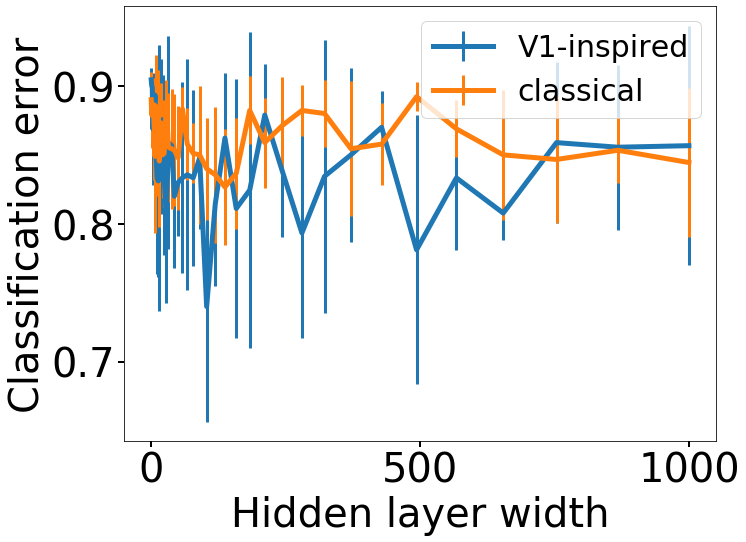

In [56]:
fig = plt.figure(figsize=(10.6, 8))
ax = fig.add_subplot(111)
ax.errorbar(n_features, results['V1']['avg_test_err'], yerr=results['V1']['std_test_err'], fmt='-', 
            label='V1-inspired',  markersize=4, lw=5, elinewidth=3)
ax.errorbar(n_features, results['classical']['avg_test_err'], yerr=results['classical']['std_test_err'], 
            fmt='-', label='classical', markersize=4, lw=5, elinewidth=3)
plt.xlabel('Hidden layer width', fontsize=40)
plt.ylabel('Classification error', fontsize=40)
# plt.xticks(np.arange(0, 1020, 200))
# plt.xlim([0, 1000])
# plt.yticks(np.arange(0, 0.6, 0.1))
# plt.ylim([-0.05, 0.55])
# plt.xticks(np.arange(0, 255, 50))
ax.tick_params(axis = 'both', which = 'major', labelsize = 40, width=2, length=6)

plt.legend(loc = 'upper right', fontsize=30)

### test

In [9]:
data, labels = load_omniglot('data/omniglot-py/')

# load 20 characters out of the datasets
i = np.random.choice(964, 10, replace=False)
idx = np.isin(labels, i)
X, y = data[idx].reshape(-1, 11025), labels[idx]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=10, stratify=y, random_state=42)

In [15]:
from estimator import V1_inspired_weights
from sklearn.svm import LinearSVC

In [17]:
W = V1_inspired_weights(10, X_train.shape[1], t=5, l=3, random_state=42)

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

1225